In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
try:
    import empyrical as emp
except:
    emp = None
import tushare as ts
import time
import random
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq
from spider.spider_coinmarketcap import Spider_coinmarketcap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
CRYPTOCURRENCY = list(CRYPTOCURRENCY.keys())
NASDAQ100 = CONF['NASDAQ100']
HS300 = list(ts.get_hs300s()['code'])

BENCHMARK = '399300'
# TARGET = ['399300']
TARGET = HS300
# BENCHMARK = 'NDX'
# TARGET = NASDAQ100
# BENCHMARK = 'BITCOIN'
# TARGET = CRYPTOCURRENCY

ALL_TARGET = TARGET[:]

pd

<module 'pandas' from 'd:\\python36\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

IS_DOWNLOAD_DATA = False
spider_n = Spider_nasdaq()
spider_c = Spider_coinmarketcap()
timeframe = '10y'
ignore = True

for symbol in TARGET + [BENCHMARK]:
    if not IS_DOWNLOAD_DATA:
        break

    # 沪深300指数
    if symbol == '399300':
        df = ts.get_k_data(code=symbol, index=True, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # A股
    elif symbol in HS300:
        df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2005-01-01', end=time.strftime('%Y-%m-%d'))
        datafile = '../database/market/%s.csv' % symbol
        df.to_csv(datafile, index=False, encoding='utf-8')
        
    # NASDAQ
    elif symbol in NASDAQ100:
        datafile = None
        while datafile is None:
            try:
                datafile = spider_n.get_stock_data(symbol, timeframe)
            except:
                time.sleep(5)
    
    # CRYPTOCURRENCY
    elif symbol in CRYPTOCURRENCY:
        datafile = spider_c.get_coin_data(symbol, start_date='20100101', end_date=time.strftime('%Y%m%d'))
        
    print(datafile)
    time.sleep(1)

Wall time: 0 ns


In [3]:
%%time

### 时间设置
start_date = '2005-01-01'
# start_date = '2006-01-01'
# start_date = '2007-01-01'
# start_date = '2008-01-01'
# start_date = '2009-01-01'
# start_date = '2010-01-01'
# start_date = '2011-01-01'
# start_date = '2012-01-01'
# start_date = '2013-01-01'
# start_date = '2014-01-01'
# start_date = '2015-01-01'
# start_date = '2015-07-01'
# start_date = '2016-01-01'
# start_date = '2017-01-01'
# start_date = '2018-01-01'
# start_date = '2018-08-01'
# end_date = '2016-01-01'
end_date = '2018-08-01'

TURTLE_POS = 20
### Turtle System One - Short
TURTLE_SHORT_BUY_N = 20
TURTLE_SHORT_SELL_N = 20
### Turtle System Two - Long
TURTLE_LONG_BUY_N = 60
TURTLE_LONG_SELL_N = 60

### 业务设置
IS_HAPPYMONEY = False
IS_TAX = False
IS_SLIPPAGE = False
IS_RANDOM_BUY = False
IS_FILTER = False
IS_MARKETUP = True
IS_BUYBENCHMARK = True
IS_SHOWBUYLIST = True
START_MONEY = 1000000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY


Wall time: 0 ns


In [4]:
%%time

stock_df_dict = {}

for symbol in TARGET + [BENCHMARK]:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ100:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    if symbol in NASDAQ100 or symbol in CRYPTOCURRENCY:
        stock_df = stock_df[::-1]
    stock_df.set_index(['date'], inplace=True)
    stock_df.index = stock_df.index.to_period('D')

    # 计算每天涨跌幅
    stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
#     stock_df['pre_close'] = stock_df.close.shift(1)
#     stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.pre_close) / stock_df.pre_close
    stock_df['c_o_pct_chg'] = (stock_df.open - stock_df.close.shift(1)) / stock_df.close.shift(1)
    
    # Turtle指标
#     stock_df['TR1'] = abs(stock_df['high'] - stock_df['low'])
#     stock_df['TR2'] = abs(stock_df['high'] - stock_df['close'].shift())
#     stock_df['TR3'] = abs(stock_df['low'] - stock_df['close'].shift())
#     stock_df['TR'] = stock_df[['TR1', 'TR2', 'TR3']].max(axis=1)
#     stock_df['N'] = stock_df['TR'].rolling(20).mean()
#     stock_df['UNIT'] = (0.01 * START_MONEY) / (stock_df['N'])
#     stock_df['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N] = stock_df['open'].rolling(TURTLE_SHORT_BUY_N).max()
#     stock_df['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N] = stock_df['open'].rolling(TURTLE_SHORT_SELL_N).min()
    stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
    stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
#     stock_df['EWMA'] = stock_df['open'].ewm(alpha=0.1, adjust=False).mean()
#     stock_df['MA360'] = stock_df['open'].rolling(360).mean()
    stock_df['MA180'] = stock_df['open'].rolling(180).mean()
    stock_df['MA60'] = stock_df['open'].rolling(60).mean()
    stock_df['MA30'] = stock_df['open'].rolling(30).mean()
    
    # 减少数据
    # stock_df = stock_df['2016-01-01':]
    stock_df.dropna(how='any', inplace=True)
#     stock_df.drop(columns=['volume', 'TR1', 'TR2', 'TR3'], inplace=True)
    
    stock_df_dict[symbol] = stock_df

Wall time: 4.65 s


In [5]:
'''抽查数据'''

stock_df_dict[BENCHMARK].head(2)
stock_df_dict[BENCHMARK].tail(2)

df = stock_df_dict[BENCHMARK].iloc[:].copy()
df.columns
df.reset_index(drop=False, inplace=True)
# df = df.astype(dtype={'date': 'datetime64[ns]'})
df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
df.set_index('date', inplace=True)
display_charts(df, chart_type='stock', kind='line', y=['open', 'ROLLING_60_MAX', 'ROLLING_60_MIN', 'MA60', 'MA180'], figsize=(900, 600))

'抽查数据'

,open,close,o_pct_chg,c_o_pct_chg,ROLLING_60_MAX,ROLLING_60_MIN,MA180,MA60,MA30
date,,,,,,,,,
2005-12-29,921.14,932.03,0.002274,0.000239,923.43,855.45,900.228556,888.027833,887.838667
2005-12-30,933.45,923.45,0.013364,0.001524,933.45,855.45,899.944056,888.308833,890.201000


,open,close,o_pct_chg,c_o_pct_chg,ROLLING_60_MAX,ROLLING_60_MIN,MA180,MA60,MA30
date,,,,,,,,,
2018-08-16,3251.86,3276.73,-0.035617,-0.012187,3853.29,3251.86,3864.277056,3553.729000,3429.283333
2018-08-17,3305.90,3229.62,0.016618,0.008902,3846.94,3251.86,3859.235500,3544.605833,3427.911333


Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'ROLLING_60_MAX',
       'ROLLING_60_MIN', 'MA180', 'MA60', 'MA30'],
      dtype='object')

In [6]:
'''用基准数据来存储策略数据'''
show_df = None
show_df = stock_df_dict[BENCHMARK].copy()
show_df.loc[:, 'CASH_TURTLE'] = START_MONEY
show_df.loc[:, 'PROPERTY_TURTLE'] = START_MONEY

'用基准数据来存储策略数据'

In [7]:
%%time
# %xmode

'''简易海龟策略，唐安奇通道突破信号，平均分头寸'''

PROPERTY = START_MONEY
CASH = START_MONEY
count_day = 0
yesterday = None
miss_buy_short = 0
miss_buy_long = 0

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])

ops_df = None
ops_df = pd.DataFrame(columns=[
    'ops_date', 'ops', 'symbol', 'count', 'price', 'reason', 'profit'
])


# 时间序列
for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    count_day += 1
    
    # 每年年初计算回报率
    if today.dayofyear == 1 or today == (pd.to_datetime(end_date)).to_period(freq='D'):
        if today.dayofyear == 1:
            lastyear_firstday = pd.to_datetime('%d-01-01' % (today.year - 1))
        else:
            lastyear_firstday = pd.to_datetime('%d-01-01' % today.year)
        lastyear_firstday = lastyear_firstday.to_period(freq='D')
#         print(today, show_df.iloc[0].name, show_df[:today].iloc[-1].PROPERTY_TURTLE)
        if today > show_df.iloc[0].name:
            today_property = show_df[:today].iloc[-2].PROPERTY_TURTLE
#             print(show_df[:today].iloc[-1])
        else:
            today_property = show_df.iloc[0].PROPERTY_TURTLE
        if lastyear_firstday > show_df.iloc[0].name:
            lastyear_firstday_property = show_df[:lastyear_firstday].iloc[-1].PROPERTY_TURTLE
        else:
            lastyear_firstday_property = show_df.iloc[0].PROPERTY_TURTLE
        lastyear_return = round((today_property - lastyear_firstday_property) / lastyear_firstday_property, 4)
        print(lastyear_firstday, today, lastyear_firstday_property, today_property, lastyear_return)
    
    # 每年筛股
    if IS_FILTER and (today.dayofyear == 1 or count_day == 1):
        TARGET = ALL_TARGET[:]
        benchmark_lastyear = stock_df_dict[BENCHMARK][:today]
        
        # 不到一年（250个交易日）
        if len(benchmark_lastyear) < 250:
            continue
        
        # 筛选过滤
        benchmark_return_lastyear = benchmark_lastyear.iloc[-1].open / benchmark_lastyear.iloc[-250].open
        for symbol, stock_df in stock_df_dict.items():
            try:
                return_lastyear = stock_df[:today].iloc[-1].open / stock_df[:today].iloc[-250].open
                if return_lastyear < benchmark_return_lastyear:
                    TARGET.remove(symbol)
#                     print(symbol, return_lastyear)
            except:
                TARGET.remove(symbol)
                pass
        print(today, 'TARGET after filter', len(TARGET))
        
    
    if yesterday is None:
        yesterday = today
        continue

    # 日期不在基准交易日，则不交易
    if today not in stock_df_dict[BENCHMARK].index:
        continue
            
    # 突破下行趋势，清仓退出
    order_arr = order_df.to_records(index=False)
    if len(order_arr[(order_arr.buy_count > 0) & (order_arr.sell_price == 0)] ) != 0:
        is_sell = False
        for idx in order_df[(order_df['buy_count'] > 0) & (order_df['sell_price'] == 0)].index:
            cur_order = order_df.loc[idx]
            symbol = cur_order['symbol']
            if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
                continue
            today_market = stock_df_dict[symbol].loc[today]
            if today_market.c_o_pct_chg < -0.1 and symbol in HS300:
#                 print(today, symbol, '跌停板，卖不掉')
                continue
            if cur_order.buy_reason == 'SHORT':
                is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N])
            if cur_order.buy_reason == 'LONG':
                is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N])
#                 is_sell = (today_market.MA60 <= today_market.MA180)
#                 is_sell = (today_market.MA30 <= today_market.MA60)
            if is_sell:
                CASH += cur_order.buy_count * today_market.open
                order_df.loc[idx, 'sell_date'] = today
                order_df.loc[idx, 'sell_price'] = today_market.open
                order_df.loc[idx, 'sell_reason'] = 'EXIT'
                order_df.loc[idx, 'profit'] = \
                    (today_market.open - cur_order.buy_price) * cur_order.buy_count
#                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)
                
                ops_df = ops_df.append(
                    {
                        'ops_date': today,
                        'ops': 'SELL',
                        'symbol': symbol,
                        'count': cur_order.buy_count,
                        'price': today_market.open,
                        'reason': cur_order.buy_reason,
                        'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
                    },
                    ignore_index=True
                )

    # 开心止盈，倍数止盈
    if IS_HAPPYMONEY:        
        if PROPERTY > START_MONEY * 2 and CASH > START_MONEY:
            HAPPY_MONEY += START_MONEY
            PROPERTY -= START_MONEY
            CASH -= START_MONEY
    
    benchmark_today_market = stock_df_dict[BENCHMARK].loc[today]
    try:
        benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-2]
    except:
        benchmark_yesterday_market = stock_df_dict[BENCHMARK].loc[:today].iloc[-1]
    buy_list = []
    
    # 遍历标的，判断和执行买入
    for symbol in TARGET:
        
        # 趋势交易，只在好行情时买入
        if IS_MARKETUP:
            if benchmark_today_market.MA60 < benchmark_today_market.MA180:
#             if benchmark_yesterday_market.MA60 < benchmark_yesterday_market.MA180:
                break
        
        # 是否购买基准
        if not IS_BUYBENCHMARK and symbol == BENCHMARK:
            continue
        
        if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
            continue
            
        # TIME TEST
        # DELETED

        today_market = stock_df_dict[symbol].loc[today]

        # 突破上行趋势，就买一份
        order_arr = order_df.to_records(index=False)
        is_buy = False
#         if today_market.MA60 >= today_market.MA180:
#         if today_market.MA30 >= today_market.MA60:
#         if today_market.MA30 >= today_market.MA180:
        # 指数就不要过滤器了
        if True:
            if today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N]:
#             if today_market.MA60 > today_market.MA180:
#             if today_market.MA30 > today_market.MA60:
                is_buy = True
                buy_reason = 'LONG'
            elif False and today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N]:
                is_buy = True
                buy_reason = 'SHORT'

        if is_buy:
            buy_list.append(symbol)
            
    if IS_RANDOM_BUY:
        random.shuffle(buy_list)
    else:
        tmp_list = []
        for symbol in buy_list:
            try:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[-250].open
            except:
                return_lastyear = stock_df_dict[symbol][:today].iloc[-1].open / stock_df_dict[symbol][:today].iloc[1].open
            tmp_list.append((return_lastyear, symbol))
        tmp_list = sorted(tmp_list, reverse=True)
        buy_list = [x[1] for x in tmp_list if x[0]>1]
#         buy_list = [x[1] for x in tmp_list]
    
    for symbol in buy_list:
        today_market = stock_df_dict[symbol].loc[today]
        buy_count = 0
                
        # 滑点
        if IS_SLIPPAGE:
            buy_price = today_market.open * (1 + random.randint(0, 20) / 1000)
        else:
            buy_price = today_market.open
                
        # 按份数买
        if CASH >= PROPERTY / TURTLE_POS:
            buy_count = int((PROPERTY / TURTLE_POS) / buy_price)

        # 指数购买，满仓干
#         buy_count = int(CASH / buy_price)

        if buy_count > 0:
            if today_market.c_o_pct_chg > 0.1 and symbol in HS300:
#                 print(today, symbol, '涨停板，买不进')
                continue
            
        if buy_count > 0:
            CASH -= buy_count * buy_price
#             print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
            order_df = order_df.append(
                {
                    'buy_date': today,
                    'symbol': symbol,
                    'buy_count': buy_count,
                    'buy_price': today_market.open,
                    'buy_reason': buy_reason,
                    'sell_date': pd.np.nan,
                    'sell_price': 0,
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
            ops_df = ops_df.append(
                {
                    'ops_date': today,
                    'ops': 'BUY',
                    'symbol': symbol,
                    'count': buy_count,
                    'price': buy_price,
                    'reason': buy_reason,
                    'profit': 0,
                },
                ignore_index=True
            )
        else:
            if buy_reason == 'LONG':
                miss_buy_long += 1
            elif buy_reason == 'SHORT':
                miss_buy_short += 1
            
    # 每天盘点财产
    # 闲钱进行T+0无风险投资，如货币基金
#     CASH = CASH * (1 + 0.04 / 365)
    show_df.loc[today, 'CASH_TURTLE'] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY_TURTLE'] = PROPERTY

    yesterday = today


    
# 最后一天，清仓
order_arr = order_df.to_records(index=False)
for idx in order_df[order_df['sell_price'] == 0].index:
    cur_order = order_df.loc[idx]
    symbol = cur_order['symbol']
    today_market = stock_df_dict[symbol][:today].iloc[-1]
    CASH += cur_order.buy_count * today_market.open
    order_df.loc[idx, 'sell_date'] = today
    order_df.loc[idx, 'sell_price'] = today_market.open
    order_df.loc[idx, 'sell_reason'] = 'EXIT'
    order_df.loc[idx, 'profit'] = \
        (today_market.open - cur_order.buy_price) * cur_order.buy_count
    ops_df = ops_df.append(
        {
            'ops_date': today,
            'ops': 'SELL',
            'symbol': symbol,
            'count': cur_order.buy_count,
            'price': today_market.open,
            'reason': cur_order.buy_reason,
            'profit': (today_market.open - cur_order.buy_price) * cur_order.buy_count,
        },
        ignore_index=True
    )


print('START_MONEY', START_MONEY)
print('CASH', CASH)
print('HAPPY_MONEY', HAPPY_MONEY)
print('PROPERTY', PROPERTY)

s_p = stock_df_dict[BENCHMARK][start_date:].iloc[0].open
e_p = stock_df_dict[BENCHMARK][:end_date].iloc[-1].open
print('BENCHMARK', s_p, e_p, e_p / s_p)


2004-01-01 2005-01-01 1000000.0 1000000.0 0.0
2005-01-01 2006-01-01 1000000.0 1000000.0 0.0
2006-01-01 2007-01-01 1000000.0 1946379.525 0.9464
2007-01-01 2008-01-01 1947993.4649999999 9024773.575 3.6329
2008-01-01 2009-01-01 9344863.455000002 8141032.282 -0.1288
2009-01-01 2010-01-01 8141032.282 12512830.168000001 0.537
2010-01-01 2011-01-01 12431378.724 12957795.909 0.0423
2011-01-01 2012-01-01 13241938.974000003 10721070.868 -0.1904
2012-01-01 2013-01-01 10721070.868 12704042.771999998 0.185
2013-01-01 2014-01-01 12726431.912999999 17213384.24 0.3526
2014-01-01 2015-01-01 17099539.677 25003119.336999997 0.4622
2015-01-01 2016-01-01 24048208.010000005 39345486.69800001 0.6361
2016-01-01 2017-01-01 39409397.712000005 38697876.147 -0.0181
2017-01-01 2018-01-01 38662013.206999995 48978895.63100001 0.2668
2018-01-01 2018-08-01 49108716.13999999 46064944.767000005 -0.062
START_MONEY 1000000
CASH 46230345.525000006
HAPPY_MONEY 0
PROPERTY 46230345.525000006
BENCHMARK 921.14 3530.03 3.8322404

In [8]:
symbol = BENCHMARK
# symbol = '600109'

df = order_df.copy()
df = df.astype(dtype={'cash': 'int', 'profit': 'int'})
df[df.symbol == symbol]

df = ops_df.copy()
df
# df[df.symbol == symbol]
# df[(df.ops_date > pd.to_datetime('2015-01-01').to_period(freq='D')) & (df.ops_date < pd.to_datetime('2016-01-01').to_period(freq='D'))]

,buy_date,symbol,buy_count,buy_price,buy_reason,sell_date,sell_price,sell_reason,profit,cash,property


,ops_date,ops,symbol,count,price,reason,profit
0,2006-01-19,BUY,600030,30321,1.649,LONG,0
1,2006-01-19,BUY,600489,42808,1.168,LONG,0
2,2006-01-19,BUY,600000,27337,1.829,LONG,0
3,2006-01-19,BUY,000402,18896,2.646,LONG,0
4,2006-01-19,BUY,600688,20366,2.455,LONG,0
5,2006-01-19,BUY,600887,35087,1.425,LONG,0
6,2006-01-19,BUY,600010,57803,0.865,LONG,0
7,2006-01-19,BUY,000623,34036,1.469,LONG,0
8,2006-01-19,BUY,600028,20533,2.435,LONG,0
9,2006-01-19,BUY,000895,17409,2.872,LONG,0


In [9]:
# df = stock_df_dict['600436'].iloc[:].copy()
# df.columns
# df.reset_index(drop=False, inplace=True)
# # df = df.astype(dtype={'date': 'datetime64[ns]'})
# df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
# df.set_index('date', inplace=True)
# # display_charts(df, chart_type='stock', kind='line', y=['open', 'ROLLING_60_MAX', 'ROLLING_60_MIN', 'MA60', 'MA180'], figsize=(900, 600))
# display_charts(df, chart_type='stock', kind='line', y=['open', 'ROLLING_60_MAX', 'ROLLING_30_MIN'], figsize=(900, 600))

In [10]:
'ALL'
'start_date', start_date
'end_date', end_date
'TURTLE_POS', TURTLE_POS
'TURTLE_SHORT_BUY_N', TURTLE_SHORT_BUY_N
'TURTLE_SHORT_SELL_N', TURTLE_SHORT_SELL_N
'TURTLE_LONG_BUY_N', TURTLE_LONG_BUY_N
'TURTLE_LONG_SELL_N', TURTLE_LONG_SELL_N
### 业务设置
'IS_HAPPYMONEY', IS_HAPPYMONEY
'IS_TAX', IS_TAX
'IS_SLIPPAGE', IS_SLIPPAGE
'IS_RANDOM_BUY', IS_RANDOM_BUY
'IS_FILTER', IS_FILTER
'IS_MARKETUP', IS_MARKETUP
'IS_BUYBENCHMARK', IS_BUYBENCHMARK
'START_MONEY', START_MONEY

'len(order_df)', len(order_df)
sum_profit = sum(list(order_df['profit']))
'sum_profit', sum_profit
# sum_tax = sum(list(order_df_TB['tax']))
sum_tax = 0
'sum_tax', sum_tax
'win_rate', len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0])
'annual_return', ((sum_profit - sum_tax) / START_MONEY + 1) ** (365 / count_day)
'len(order_df[order_df.profit != 0])', len(order_df[order_df.profit != 0])
'len(order_df[order_df.profit > 0])', len(order_df[order_df.profit > 0])
'order LONG', len(order_df[order_df.buy_reason == 'LONG'])
len(order_df[(order_df.buy_reason == 'LONG') & (order_df.profit > 0)])
sum(list(order_df[order_df.buy_reason == 'LONG']['profit']))
'order SHORT', len(order_df[order_df.buy_reason == 'SHORT'])
len(order_df[(order_df.buy_reason == 'SHORT') & (order_df.profit > 0)])
sum(list(order_df[order_df.buy_reason == 'SHORT']['profit']))

df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
algo = df['PROPERTY_TURTLE'].pct_change()
benchmark = df.open.pct_change()

if emp:
    'cum_returns', emp.cum_returns(algo)[-1], emp.cum_returns(benchmark)[-1]
    'max_drawdown', emp.max_drawdown(algo), emp.max_drawdown(benchmark)
    'annual_return', emp.annual_return(algo), emp.annual_return(benchmark)
    'annual_volatility', emp.annual_volatility(algo, period='daily')
    'calmar_ratio', emp.calmar_ratio(algo)
    'sharpe_ratio', emp.sharpe_ratio(returns=algo)
    'alpha', emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00)
    'beta', emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00)

'ALL DAY', len(df)
'CASH_TURTLE'
'PROPERTY_TURTLE'
'CASH NOT USED DAY', len(df[df['CASH_TURTLE'] > (df['PROPERTY_TURTLE'] / TURTLE_POS)])
'MISS_BUY_SIGNAL_LONG', miss_buy_long
'MISS_BUY_SIGNAL_SHORT', miss_buy_short

'ALL'

('start_date', '2005-01-01')

('end_date', '2018-08-01')

('TURTLE_POS', 20)

('TURTLE_SHORT_BUY_N', 20)

('TURTLE_SHORT_SELL_N', 20)

('TURTLE_LONG_BUY_N', 60)

('TURTLE_LONG_SELL_N', 60)

('IS_HAPPYMONEY', False)

('IS_TAX', False)

('IS_SLIPPAGE', False)

('IS_RANDOM_BUY', False)

('IS_FILTER', False)

('IS_MARKETUP', True)

('IS_BUYBENCHMARK', True)

('START_MONEY', 1000000)

('len(order_df)', 286)

('sum_profit', 45230345.52500001)

('sum_tax', 0)

('win_rate', 0.486013986013986)

('annual_return', 1.3258522906905728)

('len(order_df[order_df.profit != 0])', 286)

('len(order_df[order_df.profit > 0])', 139)

('order LONG', 286)

139

45230345.52500001

('order SHORT', 0)

0

0

('ALL DAY', 3061)

'CASH_TURTLE'

'PROPERTY_TURTLE'

('CASH NOT USED DAY', 1311)

('MISS_BUY_SIGNAL_LONG', 27868)

('MISS_BUY_SIGNAL_SHORT', 0)

In [11]:
'''计算标的持有、收益等'''

df = order_df.copy()
df.drop(columns=['sell_reason'], inplace=True)
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
# df.sell_date.dtypes
# df.loc[1].sell_date
# df.loc[1].sell_date.to_timestamp()

# df = df.astype(dtype={'sell_date': 'datetime64[ns]', 'buy_date': 'datetime64[ns]', 'cash':'int'})
df = df.astype(dtype={'cash': 'int', 'profit': 'int'})
# df.loc[1].sell_date

# type(df[1].sell_date)
df['h_days'] = (df.sell_date - df.buy_date)
# df.loc[1].h_days
# type(df.loc[1].h_days)

df['h_days'] = df['h_days'].apply(lambda x: 1 if x == 0 else x)
# df.loc[1].h_days

df['per_d'] = df.pro_pct / df.h_days * 365
# df['per_d'] = df.apply(lambda x: x.pro_pct / x.h_days)

# df
# df.sort_values(by='pro_pct', ascending=False)
# df.sort_values(by='per_d', ascending=False)

df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
df.sort_values(by='pro_pct', ascending=False).head(5)

'计算标的持有、收益等'

,pro_pct
symbol,
000623,17.773821
600109,17.330456
600031,10.862659
002252,10.531789
300033,10.205026


In [12]:
'''策略评价'''

strategy_result = None
strategy_result = pd.DataFrame(columns=[
    'strategy', 'ops', 'symbol', 'count', 'price', 'reason', 'profit'
])


'策略评价'

Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'ROLLING_60_MAX',
       'ROLLING_60_MIN', 'MA180', 'MA60', 'MA30', 'CASH_TURTLE',
       'PROPERTY_TURTLE'],
      dtype='object')

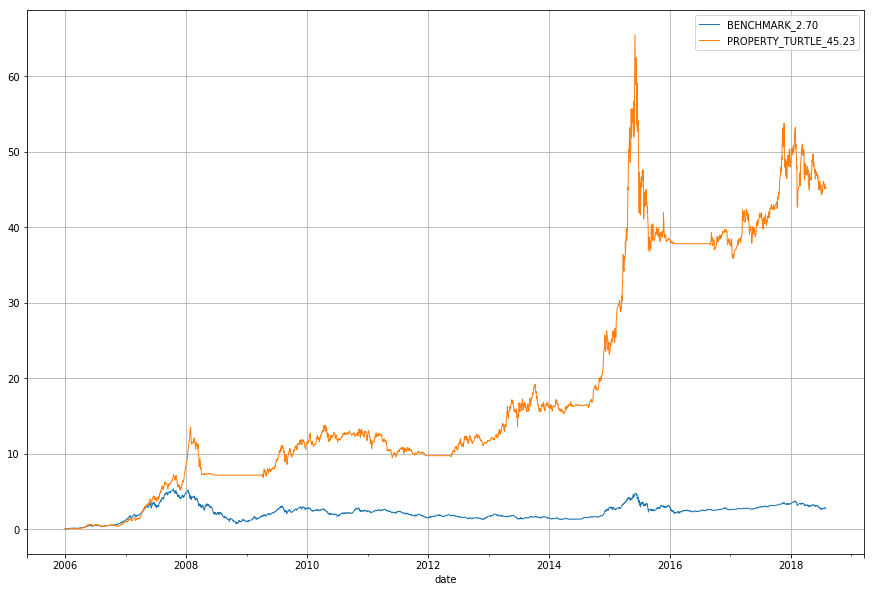

In [13]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# df = show_df.fillna(START_MONEY).copy()
df = show_df.dropna(how='any', inplace=False).copy()
df = df.loc[start_date:end_date]
# df.drop(columns=['open', 'high', 'low', 'o_pct_chg', 'TR', 'N'], inplace=True)
df.columns

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
ax = df.plot(kind='line', y='close', label='BENCHMARK_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        ax = df.plot(kind='line', y=col, secondary_y=False, label='%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

# display_charts(df, kind='line', figsize=(900, 600), logy=False)

In [14]:
df = show_df.dropna(how='any', inplace=False).copy()
# df.drop(columns=['open', 'high', 'low', 'o_pct_chg', 'TR', 'N'], inplace=True)
df = df.loc[start_date:end_date]
df.columns

show_columns = ['close']
df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        show_columns.append(col)
    if 'CASH' in col:
        df[col] = df[col] / df.iloc[0][col]
        show_columns.append(col)

# df = df.loc[:, ['close', 'CASH_TURTLE_20_60_60', 'PROPERTY_TURTLE_20_60_60']]
df = df.loc[:, show_columns]
df.reset_index(drop=False, inplace=True)
# df.dtypes
# df.iloc[0].date
# df.iloc[0].date.to_timestamp()
# df.iloc[0].date.to_timestamp().to_datetime64()
df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
# df.iloc[0].date
df.set_index(keys=['date'], inplace=True)
# df

display_charts(df, chart_type='stock', figsize=(900, 600), logy=False)

Index(['open', 'close', 'o_pct_chg', 'c_o_pct_chg', 'ROLLING_60_MAX',
       'ROLLING_60_MIN', 'MA180', 'MA60', 'MA30', 'CASH_TURTLE',
       'PROPERTY_TURTLE'],
      dtype='object')